# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

from IPython.display import display

# Fichier avec labels (étiquettes)

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Ensemble avec des étiquettes (notre train+test) :', data.shape)

Ensemble avec des étiquettes (notre train+test) : (284580, 6)


In [3]:
def describe_df(df):
    """
    Affiche plusieurs informations statistiques sur le DataFrame donné.

    Paramètres:
    df: pandas.DataFrame
        Le DataFrame pour lequel afficher les informations.

    Affiche:
    - Le nombre de lignes dans le DataFrame.
    - Les premières lignes du DataFrame pour vérifier l'apparence des données.
    - Des statistiques de base pour chaque colonne (ex: nombre, moyenne, min, max pour les colonnes numériques ; nombre, unique, top, freq pour les colonnes de type objet).
    - Le pourcentage de valeurs manquantes pour chaque colonne.

    Note:
    Cette fonction n'a pas de valeur de retour, elle affiche seulement les informations.
    """
    print('Nombre de lignes :',len(df))
    print('Affichage du jeu de données :')
    display(df.head())
    print('Statistiques de base :')
    display(df.describe(include="all"))
    print('Pourcentage de valeurs manquantes :')
    display(df.isnull().sum()/len(df)*100)

In [4]:
describe_df(data)

Nombre de lignes : 284580
Affichage du jeu de données :


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


Statistiques de base :


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Pourcentage de valeurs manquantes :


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [5]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Exploration du dataset

Nous avons un jeu de donnée de 284 500 lignes avant préprocessing.


features

country : Pays d'origine de l'utilisateur.
age : Âge de l'utilisateur.
new_user : Indique si l'utilisateur est un nouvel utilisateur ou non.
total_pages_visited : Nombre total de pages visitées par l'utilisateur.


Target

converted : Indique si l'utilisateur a converti (1) ou non (0).


Statistiques des caractéristiques :


country : 4 pays uniques, US étant le plus fréquent.
age : Moyenne d'âge de 30.56 ans, avec un écart type de 8.27 ans.
new_user : 68.55% des utilisateurs sont de nouveaux utilisateurs.
source : SEO, ADS, Direct. Seo étant la plus fréquente.
total_pages_visited : Moyenne de 4.87 pages visitées, avec un écart type de 3.34.



Statistiques de la variable cible :


converted : Taux de conversion moyen de 3.23%.


Le jeu de donnée ne possède aucune donnée manquantes, c'est un point important pour la mise en place de pipeline par la suite.
Cependant, il est important de noter que nous sommes dans une situation déséquilibre de classes, aussi appelé imbalanced dataset.
Autrement dit, la classe convertie est nettement moins représentée que la convertie.


Il est crucial de prendre en compte ce déséquilibre lors de la modélisation, car les modèles de machine learning peuvent avoir tendance à privilégier la classe majoritaire et à ne pas bien généraliser la classe minoritaire.

Cela peut conduire à des prédictions biaisées et peu précises pour la classe sous-représentée.

In [6]:
# L'ensemble de données est assez grand : vous devez créer un échantillon de l'ensemble de données avant de faire des visualisations !
data_sample = data.sample(10000)

In [7]:
target = 'converted'

num_features = [c for c in data.columns if c != target]
cat_order = {
    'converted': [0, 1]
}


def display_distribution(c):
    fig = px.histogram(data, c, color=target, facet_row=target, histnorm='probability')
    fig.update_layout(width=700, height=500)
    fig.update_layout(bargap=0.1)
    fig.show()

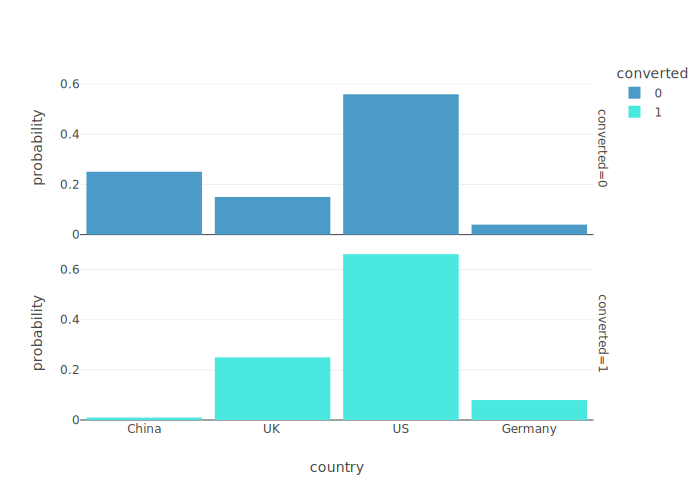

In [8]:
display_distribution(num_features[0])

La majorité des visiteurs sont situés aux US et UK, il est très probable les fondateurs du site soit anglophones. Du moins que le site ne soit pas destiné ou adapté à un public chinois. En effet, les pays européens et US semblent avoir des meilleurs conversions qu'en Chine. Pour quelles raisons ? Une hypothèse serait la barrière de la langue.

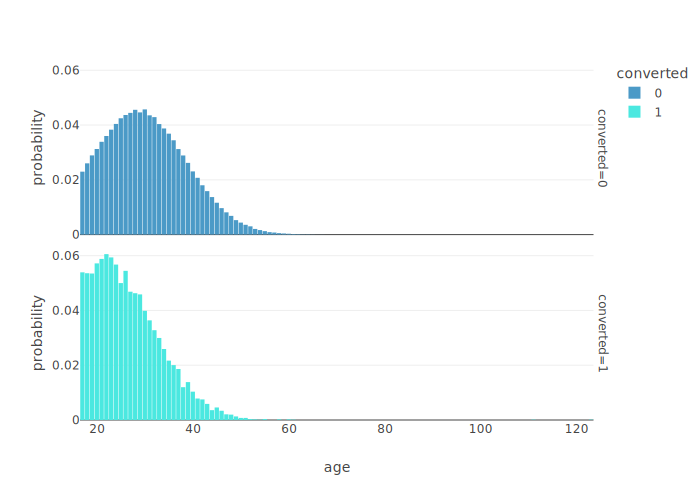

In [60]:
display_distribution(num_features[1])

Comme remarqué sur le descriptif du dataset plus haut, on observe des valeurs d'age extrêmes (>100 ans) et peu representée, sur 280 000 valeurs on peut négliger leur influence et les conserver.

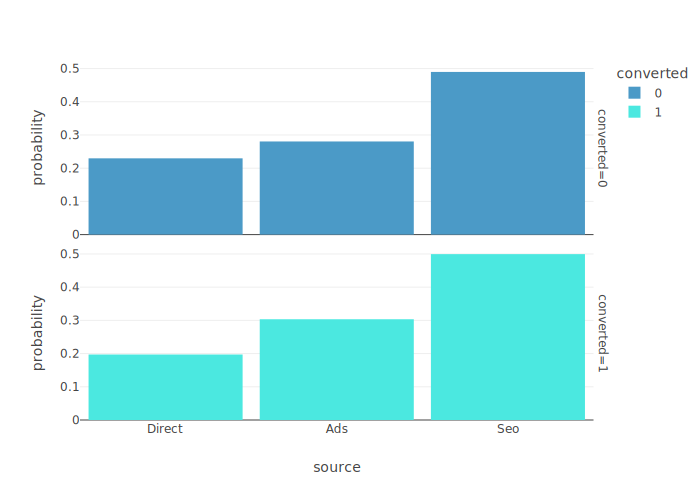

In [9]:
display_distribution(num_features[3])

La majorité des visiteurs, qu'ils convertissent ou non, arrivent principalement grâce au référencement naturel (SEO). Il est logique que la publicité attire plus de visiteurs sur le site que la recherche directe de l'URL par l'utilisateur. Cependant, le fait que la publicité génère moins de trafic que le référencement naturel suggère que soit la stratégie publicitaire pourrait être améliorée, soit que leur travail de référencement naturel est particulièrement efficace.

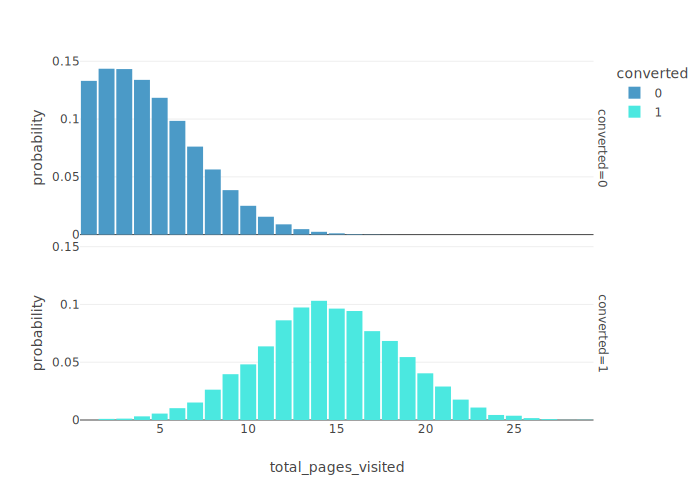

In [10]:
display_distribution(num_features[4])

On devine une tendance d'augmentation de la conversion face au nombre de visite. 

# Construction du modèle

## Choisissez les variables à utiliser dans le modèle, et créez des ensembles d'apprentissage et de test
**D'après l'EDA, nous savons que la caractéristique la plus utile est total_pages_visited. Nous allons donc créer un modèle de base en utilisant d'abord uniquement cette caractéristique : dans les cellules suivantes, nous effectuerons des prétraitements et entraînerons une simple régression logistique univariée.**

In [11]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [12]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['total_pages_visited'], dtype='object')



La majorité des visiteurs sont situés aux US et UK, il est très probable les fondateurs du site soit anglophones. Du moins que le site ne soit pas destiné ou adapté à un public chinois.

En effet, les pays européens et US semblent avoir des meilleures conversions qu'en Chine.

Pour quelles raisons ? Une hypothèse serait la barrière de la langue.

In [13]:
# Diviser le jeu de données en ensemble d'entraînement et ensemble de test
print("Division du jeu de données en ensemble d'entraînement et de test...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Terminé.")
print()

Division du jeu de données en ensemble d'entraînement et de test...
...Terminé.



## Pipeline d'entraînement

In [14]:
# Mettez ici tous les prétraitements
print("Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Terminé.")
print(X_train[0:5, :])

Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...
...Terminé.
[[-0.26070136]
 [ 0.93728655]
 [-0.85969532]
 [-0.56019834]
 [-0.26070136]]


In [15]:
# Entraînement du modèle
print("Entraînement du modèle...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Terminé.")

Entraînement du modèle...
...Terminé.


In [16]:
# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = classifier.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]



## Test pipeline

In [17]:
# Utilisez X_test, et les mêmes prétraitements que dans le pipeline d'entraînement,
# mais appelez la méthode "transform()" au lieu de la méthode "fit_transform" (voir exemple ci-dessous)

print("Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...")

X_test = featureencoder.transform(X_test)
print("...Terminé")
print(X_test[0:5, :])

Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...
...Terminé
[[ 0.63778957]
 [ 0.03879562]
 [-0.26070136]
 [-0.26070136]
 [ 0.63778957]]


In [18]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = classifier.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]



## Évaluation des performances

In [19]:
# ATTENTION : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le tableau de bord
print("f1-score sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur l'ensemble d'entraînement :  0.6938517686692869
f1-score sur l'ensemble de test :  0.7060240963855423


<div style="margin-left: 50px; >
<br>
Rappel


<span style="font-size: 14px">


Le F1-score est calculé à partir des valeurs de True Positive (TP), False Positive (FP) et False Negative (FN).

- <strong>True Positive (TP)</strong> : Le nombre d'échantillons positifs correctement classés.
- <strong>False Positive (FP)</strong> : Le nombre d'échantillons négatifs incorrectement classés comme positifs.
- <strong>False Negative (FN)</strong> : Le nombre d'échantillons positifs incorrectement classés comme négatifs.

La précision (precision) est définie comme le rapport entre TP et la somme de TP et FP :

$$ Precision = \frac{TP}{TP + FP} $$

Le rappel (recall) est défini comme le rapport entre TP et la somme de TP et FN :

$$ Recall = \frac{TP}{TP + FN} $$

Le F1-score est la moyenne harmonique de la précision et du rappel, calculée comme suit :

$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$

Le F1-score prend en compte à la fois la précision et le rappel, ce qui en fait une mesure utile pour évaluer la performance d'un modèle de classification, surtout lorsque les classes sont déséquilibrées.

</span>
</div>

In [20]:
# Vous pouvez également vérifier plus de critères de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246817   1082]
 [  3280   4943]]

Matrice de confusion sur l'ensemble de test : 
[[27384   117]
 [  371   586]]




**Notre modèle de référence atteint un f1-score de presque 70%. Vous êtes maintenant libre d'affiner votre modèle et d'essayer de battre ce score ! 🚀🚀**

# Entraînement du meilleur classificateur sur toutes les données et utilisation pour effectuer des prédictions sur X_without_labels
**Avant de faire des prédictions sur le fichier conversion_data_test.csv, entraînons notre modèle sur TOUTES les données qui étaient dans conversion_data_train.csv. Parfois cela permet de réaliser de légères améliorations de score, car nous utilisons plus d'exemples pour entraîner le modèle.**

In [21]:
# Concaténation de nos ensembles d'entraînement et de test pour entraîner le meilleur classifieur sur toutes les données avec des étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

LogisticRegression()

In [22]:
# Lecture des données sans étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de la liste des caractéristiques (doit être la même que les caractéristiques 
# utilisées par votre meilleur classificateur)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Conversion des DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5, :])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [23]:
# ATTENTION: METTEZ ICI LE MÊME PRÉ-TRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print(
    "Encodage des caractéristiques catégorielles et normalisation (standardisation) des caractéristiques numériques....")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5, :])

Encodage des caractéristiques catégorielles et normalisation (standardisation) des caractéristiques numériques....
...Terminé
[[ 3.33326238]
 [ 0.03879562]
 [-1.15919229]
 [ 0.3382926 ]
 [-0.56019834]]


In [24]:
# Faire des prédictions et les enregistrer dans un fichier
# ATTENTION : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE SEULE COLONNE NOMMÉE 'converted' ET SANS INDEX !
# ATTENTION : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[name].csv'
# où [name] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [name] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)

## Analyser les coefficients et interpréter le résultat
**Dans ce modèle, nous n'avons entraîné qu'avec une seule caractéristique (total_pages_visited), donc il n'y a pas d'analyse à faire sur l'importance des caractéristiques 🤔**

**Une fois que vous avez inclus plus de caractéristiques dans votre modèle, prenez le temps d'analyser les paramètres du modèle et essayez de trouver certains leviers d'action pour améliorer le taux de conversion de la newsletter 😎😎**

# ESSAI DE MON PREMIER MODÈLE

# Régression logistique 

Régression logistique avec toutes les colonnes du jeu de données dans la liste des caractéristiques :

In [25]:
data = pd.read_csv('conversion_data_train.csv')
print("Jeu de données avec les étiquettes (notre ensemble d'apprentissage + test):", data.shape)

Jeu de données avec les étiquettes (notre ensemble d'apprentissage + test): (284580, 6)


In [26]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [27]:
# Le jeu de données est assez grand, créez un échantillon de celui-ci avant de réaliser des visualisations !
data_sample = data.sample(10000)

In [28]:
# Statistiques de base
print("Nombre de lignes : {}".format(data.shape[0]))
print()

print("Nombre de colonnes : {}".format(data.shape[1]))
print()

print("Affichage du jeu de données : ")
display(data.head())
print()

print("Statistiques de base : ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Pourcentage de valeurs manquantes : ")
display(100*data.isnull().sum()/data.shape[0])

Nombre de lignes : 284580

Nombre de colonnes : 6

Affichage du jeu de données : 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Statistiques de base : 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Pourcentage de valeurs manquantes : 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [29]:
# En ayant recours à la méthode 'loc', nous filtrons les données pour éliminer les valeurs aberrantes au niveau de la colonne 'age'.
# Les valeurs aberrantes sont déterminées en utilisant la moyenne et l'écart type de 'age'.
# Les observations dont 'age' est plus de 4 écarts types au-dessus de la moyenne (c'est-à-dire des valeurs extrêmement élevées) seront supprimées.
data = data.loc[data['age'] < (data['age'].mean())+(data['age'].std()*4)]

In [30]:
data.info

<bound method DataFrame.info of         country  age  new_user  source  total_pages_visited  converted
0         China   22         1  Direct                    2          0
1            UK   21         1     Ads                    3          0
2       Germany   20         0     Seo                   14          1
3            US   23         1     Seo                    3          0
4            US   28         1  Direct                    3          0
...         ...  ...       ...     ...                  ...        ...
284575       US   36         1     Ads                    1          0
284576       US   31         1     Seo                    2          0
284577       US   41         1     Seo                    5          0
284578       US   31         1  Direct                    4          0
284579       US   26         0     Ads                    3          0

[284515 rows x 6 columns]>

In [31]:
# Liste des caractéristiques à considérer pour nos prédictions
features_list = ['country','age','new_user','source','total_pages_visited']

# Variable cible que nous souhaitons prédire
target_variable = 'converted'

In [32]:
# Ici, nous définissons nos variables explicatives (c'est-à-dire nos caractéristiques) et notre variable de sortie (la cible).
# 'loc' est une fonction qui nous permet de sélectionner des données par étiquette. Ici nous sélectionnons toutes les lignes (:) pour les colonnes dans 'features_list' et 'target_variable'.

X = data.loc[:, features_list]  # Variables explicatives
Y = data.loc[:, target_variable]  # Variable à prédire

# Ensuite, nous imprimons les noms des variables explicatives pour la vérification
print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [33]:
# Afin d'évaluer la performance de notre modèle, nous le divisons en deux sous-ensembles "Train" et "Test".
# L'ensemble "Train" sera utilisé pour entraîner le modèle, tandis que l'ensemble "Test" servira à évaluer sa performance.
# 'train_test_split' est une fonction qui fait exactement cela, le paramètre 'test_size=0.1' signifie que 10% des données seront utilisées pour le test.

# Le paramètre 'random_state' est utilisé pour assurer que la division soit toujours la même.

print("Diviser le dataset en ensemble d'entraînement et de test...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Terminé.")
print()

Diviser le dataset en ensemble d'entraînement et de test...
...Terminé.



In [34]:
# Ici, nous effectuons le prétraitement des données avant de les introduire dans le modèle.
# C'est une étape très importante en Machine Learning.

print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

# Nous définissons nos caractéristiques numériques
numeric_features = ['age', 'new_user', 'total_pages_visited']

# Pour nos variables numériques, nous utiliserons un `StandardScaler` qui standardise les caractéristiques en supprimant la moyenne et en choisissant l'écart type unitaire.

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Nous définissons nos caractéristiques catégoriques
categorical_features = ['country', 'source']

# Pour ces variables catégorielles, nous utiliserons un `OneHotEncoder` qui transforme chaque valeur catégorielle en une nouvelle colonne et assigne une valeur binaire 1 ou 0.

categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first')) # la première colonne sera supprimée pour éviter de créer des corrélations entre les caractéristiques
    ])

# Ensuite, nous appliquons ces transformations à nos caractéristiques en utilisant le `ColumnTransformer`.

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ])

# Enfin, nous appliquons ces transformations à notre jeu de données d'entraînement.
X_train = preprocessor.fit_transform(X_train)

print("...Terminé!")
print(X_train[0:5, :])  # On affiche les 5 premières lignes de notre jeu de données d'entraînement transformé pour la vérification.

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...
...Terminé!
[[ 0.          1.          0.          0.          1.         -1.15899784
   0.67788086  0.0377522 ]
 [ 0.          1.          0.          0.          1.         -0.43107853
   0.67788086  0.3368716 ]
 [ 0.          0.          1.          1.          0.          1.02476009
   0.67788086 -0.85960601]
 [ 0.          0.          0.          1.          0.          0.1755209
   0.67788086  0.0377522 ]
 [ 0.          0.          1.          0.          0.         -0.30975864
  -1.47518547  0.0377522 ]]


In [35]:
# Ici, nous entrainons le modèle avec nos données d'entraînement.
# Nous avons choisi d'utiliser une Régression Logistique pour notre classification qui est représentée par la variable 'classifier'.

print("Entraînement du modèle...")
# Création d'une instance de la classe LogisticRegression
classifier = LogisticRegression()
# Utilisation de l'instance créée pour entraîner le modèle sur nos données
classifier.fit(X_train, Y_train)
print("...Terminé.")

# Note : L'apprentissage du modèle est effectué lorsque nous appelons la méthode 'fit()' avec nos données d'entraînement comme paramètres.

Entraînement du modèle...
...Terminé.


In [36]:
# Ici nous faisons des prédictions sur notre ensemble d'entraînement pour vérifier comment le modèle fonctionne sur celui-ci.
print("Prédictions sur l'ensemble d'entraînement...")
# Nous utilisons la méthode 'predict' de notre classificateur pour faire les prédictions sur les données d'entraînement
Y_train_pred = classifier.predict(X_train)
print("...Terminé.")
print(Y_train_pred)  # On affiche les prédictions réalisées
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]



In [37]:
# Pour notre ensemble de test, nous appliquons les mêmes prétraitements que pour l'ensemble d'entraînement. 

print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

# Nous utilisons la méthode 'transform' et non pas 'fit_transform' car nous n'avons pas besoin d'apprendre les paramètres (moyenne, écart-type, etc.) de nos données, nous utilisons donc ceux qui ont été appris sur l'ensemble d'entraînement.
X_test = preprocessor.transform(X_test)
print("...Terminé.")

# Nous imprimons les 5 premières lignes pour vérification
print(X_test[0:5, :])

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...
...Terminé.
[[ 1.          0.          0.          0.          1.          0.66080044
  -1.47518547 -0.85960601]
 [ 0.          0.          0.          1.          0.          0.05420101
  -1.47518547  0.635991  ]
 [ 1.          0.          0.          0.          1.          0.05420101
   0.67788086 -0.56048661]
 [ 0.          0.          0.          0.          0.         -0.30975864
   0.67788086  0.3368716 ]
 [ 0.          0.          0.          1.          0.         -1.64427738
  -1.47518547  0.0377522 ]]


In [38]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = classifier.predict(X_test)
print("...Fait.")
print(Y_test_pred)
print()

Prédictions sur l'ensemble de test...
...Fait.
[0 0 0 ... 0 0 0]



In [39]:
# AVERTISSEMENT : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le tableau de classement.
print("f1-score sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur l'ensemble d'entraînement :  0.7627639668537823
f1-score sur l'ensemble de test :  0.771712158808933


In [40]:
# Vous pouvez également vérifier d'autres mesures de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246806    969]
 [  2581   5707]]

Matrice de confusion sur l'ensemble de test : 
[[27462   100]
 [  268   622]]



In [41]:
# Concaténez nos ensembles d'entraînement et de test pour entraîner votre meilleur classificateur sur toutes les données avec des étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

LogisticRegression()

In [42]:
# Lecture des données sans étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de la liste des caractéristiques (doit être la même que les caractéristiques 
# utilisées par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Conversion des DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Fait")

print(X_without_labels[0:5])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Fait
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [43]:
# ATTENTION : METTEZ ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Fait")
print(X_without_labels[0:5])


Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...
...Fait
[[ 0.          1.          0.          0.          1.         -0.30975864
  -1.47518547  3.32806563]
 [ 0.          1.          0.          1.          0.         -1.03767795
   0.67788086  0.0377522 ]
 [ 0.          0.          0.          0.          1.          0.1755209
   0.67788086 -1.15872542]
 [ 0.          0.          1.          0.          0.          0.1755209
   0.67788086  0.3368716 ]
 [ 0.          0.          0.          0.          1.         -0.6737183
  -1.47518547 -0.56048661]]


In [44]:
# Faire des prédictions et les exporter dans un fichier
# ATTENTION : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE COLONNE NOMMÉE 'converted' ET PAS D'INDEX !
# ATTENTION : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[nom].csv'
# où [nom] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [nom] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model1.csv', index=False)

# Arbre de décision

In [45]:
data = pd.read_csv('conversion_data_train.csv')
print("Ensemble avec des étiquettes (notre train+test) :", data.shape)

Ensemble avec des étiquettes (notre train+test) : (284580, 6)


In [46]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [47]:
# L'ensemble de données est assez grand : vous devez créer un échantillon de l'ensemble de données avant de faire des visualisations !
data_sample = data.sample(10000)

In [48]:
features_list = ['country','age','new_user','source','total_pages_visited']
target_variable = 'converted'

In [49]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Variables explicatoires: ', X.columns)
print()

Variables explicatoires:  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [50]:
# Diviser le jeu de données en jeu d'apprentissage et jeu de test 
print("Division en jeux d'entraînement et de test...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Terminé.")
print()

Division en jeux d'entraînement et de test...
...Terminé.



In [51]:
# Mettez ici tous les prétraitements
print("Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...")

numeric_features = ['age', 'new_user', 'total_pages_visited']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['country', 'source']
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first'))
        # la première colonne sera supprimée pour éviter de créer des corrélations entre les caractéristiques
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...


In [52]:
# Prétraitements sur l'ensemble d'entrainement
print("Réalisation de prétraitements sur l'ensemble d'entraînement...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print("...Fait.")
print(
    X_train[0:5]
)  # Il FAUT utiliser cette syntaxe car X_train est désormais un tableau numpy et non plus un DataFrame pandas
print()

# Prétraitements sur l'ensemble de test
print("Réalisation de prétraitements sur l'ensemble de test...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Ne refaites pas le fit !! L'ensemble de test est utilisé pour valider les décisions
# que nous avons prises en fonction de l'ensemble d'entraînement, par conséquent, nous ne pouvons appliquer que des transformations qui ont été paramétrées à l'aide de l'ensemble d'entraînement.
# Sinon cela crée ce qu'on appelle une fuite de l'ensemble de test qui introduira un biais dans tous vos résultats.
print("...Fait.")
print(
    X_test[0:5, :]
)  # Il FAUT utiliser cette syntaxe car X_test est désormais un tableau numpy et non plus un DataFrame pandas
print()

Réalisation de prétraitements sur l'ensemble d'entraînement...
       country  age  new_user  source  total_pages_visited
206830   China   23         0  Direct                    4
238315      US   25         1  Direct                    8
255325      US   32         1     Seo                    2
106283      US   37         1     Seo                    3
46283       UK   24         1  Direct                    4
...Fait.
[[ 0.          0.          0.          1.          0.         -0.91516278
  -1.47729174 -0.26070136]
 [ 0.          0.          1.          1.          0.         -0.67320988
   0.67691437  0.93728655]
 [ 0.          0.          1.          0.          1.          0.17362526
   0.67691437 -0.85969532]
 [ 0.          0.          1.          0.          1.          0.7785075
   0.67691437 -0.56019834]
 [ 0.          1.          0.          1.          0.         -0.79418633
   0.67691437 -0.26070136]]

Réalisation de prétraitements sur l'ensemble de test...
        coun

In [53]:
# Effectuer une recherche sur grille
print("Recherche sur grille...")
classifier = DecisionTreeClassifier()

# Grille de valeurs à tester
params = {
    "max_depth": [4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=3
)  # cv : le nombre de plis à utiliser pour la CV
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)

Recherche sur grille...
...Terminé.
Meilleurs hyperparamètres :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 8}
Meilleure précision de validation :  0.9852531215592569


In [54]:
# Prédictions sur l'ensemble d'apprentissage
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement...
...Terminé.
[[9.94529707e-01 5.47029327e-03]
 [9.93225638e-01 6.77436165e-03]
 [9.99911480e-01 8.85201953e-05]
 ...
 [9.97754625e-01 2.24537453e-03]
 [9.99580461e-01 4.19538508e-04]
 [9.99911480e-01 8.85201953e-05]]



In [55]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[9.96674848e-01 3.32515240e-03]
 [9.99580461e-01 4.19538508e-04]
 [9.98151868e-01 1.84813178e-03]
 ...
 [9.44278011e-01 5.57219892e-02]
 [9.99883327e-01 1.16672500e-04]
 [9.99911480e-01 8.85201953e-05]]



In [56]:
# ATTENTION : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le classement
print("f1-score sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur l'ensemble d'entraînement :  0.7629471436198612
f1-score sur l'ensemble de test :  0.7592165898617511


In [57]:
# Vous pouvez également vérifier d'autres indicateurs de performance pour mieux comprendre ce que votre modèle fait
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246854   1045]
 [  2507   5716]]

Matrice de confusion sur l'ensemble de test : 
[[27381   120]
 [  298   659]]



In [58]:
# Concaténation de nos ensembles d'entraînement et de test pour former votre meilleur classificateur sur toutes les données avec étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

DecisionTreeClassifier()

In [59]:
# ATTENTION : METTEZ ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5])

Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...


ValueError: X has 8 features, but ColumnTransformer is expecting 5 features as input.

In [61]:
# Faire des prédictions et les exporter vers un fichier
# ATTENTION : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE SEULE COLONNE NOMMÉE 'converted' ET SANS INDEX !
# ATTENTION : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[nom].csv'
# où [nom] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [nom] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model2.csv', index=False)

# Classifier les sacs avec un estimateur de régression logistique

In [62]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [63]:
# L'ensemble de données est assez grand : vous devez créer un échantillon de l'ensemble de données avant de faire des visualisations !
data_sample = data.sample(10000)

In [64]:
features_list = ['country','age','new_user','source','total_pages_visited']
target_variable = 'converted'

In [65]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [66]:
# Diviser le jeu de données en jeu d'entraînement et jeu de test
print("Division en ensembles d'apprentissage et de test...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Terminé.")
print()

Division en ensembles d'apprentissage et de test...
...Terminé.



In [67]:
# Mettez ici tous les prétraitements
print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

numeric_features = ['age', 'new_user', 'total_pages_visited']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['country', 'source']
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first'))
        # la première colonne sera supprimée pour éviter de créer des corrélations entre les caractéristiques
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...


In [68]:
# Prétraitements sur l'ensemble d'entraînement
print("Effectuer les prétraitements sur l'ensemble d'entraînement...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print("...Terminé.")
print(
    X_train[0:5]
)  # Vous DEVEZ utiliser cette syntaxe parce que X_train est maintenant un tableau numpy et non plus un DataFrame pandas
print()

# Prétraitements sur l'ensemble de test
print("Effectuer les prétraitements sur l'ensemble de test...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Ne pas ajuster à nouveau !! L'ensemble de test est utilisé pour valider les décisions
# que nous avons prises sur la base de l'ensemble d'entraînement, donc nous ne pouvons appliquer que des transformations qui ont été paramétrées en utilisant l'ensemble d'entraînement.
# Sinon, cela crée ce que l'on appelle une fuite de l'ensemble de test qui introduira un biais dans tous vos résultats.
print("...Terminé.")
print(
    X_test[0:5, :]
)  # Vous DEVEZ utiliser cette syntaxe parce que X_test est maintenant un tableau numpy et non plus un DataFrame pandas
print()

Effectuer les prétraitements sur l'ensemble d'entraînement...
       country  age  new_user  source  total_pages_visited
206830   China   23         0  Direct                    4
238315      US   25         1  Direct                    8
255325      US   32         1     Seo                    2
106283      US   37         1     Seo                    3
46283       UK   24         1  Direct                    4
...Terminé.
[[ 0.          0.          0.          1.          0.         -0.91516278
  -1.47729174 -0.26070136]
 [ 0.          0.          1.          1.          0.         -0.67320988
   0.67691437  0.93728655]
 [ 0.          0.          1.          0.          1.          0.17362526
   0.67691437 -0.85969532]
 [ 0.          0.          1.          0.          1.          0.7785075
   0.67691437 -0.56019834]
 [ 0.          1.          0.          1.          0.         -0.79418633
   0.67691437 -0.26070136]]

Effectuer les prétraitements sur l'ensemble de test...
        cou

In [69]:
# Effectuer la recherche de grille
print("Recherche de grille...")
regression_logistique = LogisticRegression(
    max_iter=1000
)  # max_iter modifié à cause de l'avertissement de convergence
classificateur = BaggingClassifier(estimator=regression_logistique)

# Grille de valeurs à tester
params = {
    "estimator__C": [
        0.01,
        0.05,
        0.1,
        0.5,
    ],  # préfixe base_estimator__ parce que C est un paramètre de la régression logistique!
    "n_estimators": [
        5,
        10,
        20,
        30,
    ],  # n_estimators est un hyperparamètre de la méthode d'ensemble
}
print(params)
gridsearch = GridSearchCV(
    classificateur, param_grid=params, cv=3
)  # cv : le nombre de folds à utiliser pour la validation croisée
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)
print()
print("Précision sur l'ensemble d'entraînement : ", gridsearch.score(X_train, Y_train))
print("Précision sur l'ensemble de test : ", gridsearch.score(X_test, Y_test))

Recherche de grille...
{'estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
...Terminé.
Meilleurs hyperparamètres :  {'estimator__C': 0.5, 'n_estimators': 10}
Meilleure précision de validation :  0.9863385417886787

Précision sur l'ensemble d'entraînement :  0.9863112110634775
Précision sur l'ensemble de test :  0.9852765478951437


In [70]:
# Prédictions sur l'ensemble d'entraînement 
print("Prédictions sur l'ensemble d'entraînement ...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement ...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement ...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement ...
...Terminé.
[[9.99866294e-01 1.33705741e-04]
 [9.92010100e-01 7.98989976e-03]
 [9.99936136e-01 6.38644533e-05]
 ...
 [9.98389947e-01 1.61005306e-03]
 [9.98554964e-01 1.44503590e-03]
 [9.99883741e-01 1.16259093e-04]]



In [71]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[9.93373480e-01 6.62651974e-03]
 [9.99340768e-01 6.59232233e-04]
 [9.97774783e-01 2.22521655e-03]
 ...
 [9.76352409e-01 2.36475909e-02]
 [9.99777331e-01 2.22668566e-04]
 [9.99723561e-01 2.76438630e-04]]



In [72]:
# AVERTISSEMENT : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le score f1 sera utilisé pour évaluer les performances sur le classement
print("Score f1 sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("Score f1 sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

Score f1 sur l'ensemble d'entraînement :  0.7636829334052306
Score f1 sur l'ensemble de test :  0.7548273844353424


In [73]:
# Vous pouvez également vérifier d'autres métriques de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246951    948]
 [  2558   5665]]

Matrice de confusion sur l'ensemble de test : 
[[27394   107]
 [  312   645]]



In [74]:
# Vous pouvez également vérifier d'autres métriques de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246951    948]
 [  2558   5665]]

Matrice de confusion sur l'ensemble de test : 
[[27394   107]
 [  312   645]]



In [75]:
# Lire les données sans les étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de la liste des caractéristiques (doit être la même que celle utilisée 
# par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convertir les DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminée")

print(X_without_labels[0:5])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminée
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [76]:
# AVERTISSEMENT : METTEZ ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5])

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...
...Terminé
[[ 0.          1.          0.          0.          1.         -0.31028053
  -1.47729174  3.33326238]
 [ 0.          1.          0.          1.          0.         -1.03613923
   0.67691437  0.03879562]
 [ 0.          0.          0.          0.          1.          0.17362526
   0.67691437 -1.15919229]
 [ 0.          0.          1.          0.          0.          0.17362526
   0.67691437  0.3382926 ]
 [ 0.          0.          0.          0.          1.         -0.67320988
  -1.47729174 -0.56019834]]


In [77]:
# Faire des prédictions et les exporter vers un fichier
# ATTENTION : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE COLONNE NOMMÉE 'converted' ET SANS INDICE !
# ATTENTION : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[nom].csv'
# où [nom] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [nom] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model3.csv', index=False)

# Bagging avec l'estimateur de l'arbre de décision

In [78]:
# Lire les données sans les étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de features_list (doit être la même que celle utilisée 
# par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convertir les DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [79]:
# Effectuer une recherche sur grille
print("Recherche sur grille...")
decision_tree = DecisionTreeClassifier()
classifier = BaggingClassifier(estimator=decision_tree)

# Grille de valeurs à tester
params = {
    "estimator__max_depth": [1, 2, 3],
    "estimator__min_samples_leaf": [1, 2, 3],
    "estimator__min_samples_split": [2, 3, 4],
    "n_estimators": [2, 4, 6, 8, 10],
}
print(params)
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=3
)  # cv : le nombre de plis à utiliser pour CV
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)
print()
print("Précision sur l'ensemble d'entraînement : ", gridsearch.score(X_train, Y_train))
print("Précision sur l'ensemble de test : ", gridsearch.score(X_test, Y_test))

Recherche sur grille...
{'estimator__max_depth': [1, 2, 3], 'estimator__min_samples_leaf': [1, 2, 3], 'estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Terminé.
Meilleurs hyperparamètres :  {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 2}
Meilleure précision de validation :  0.9845269051467659

Précision sur l'ensemble d'entraînement :  0.984526905146766
Précision sur l'ensemble de test :  0.9840115257572563


In [80]:
# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement...
...Terminé.
[[0.99778864 0.00221136]
 [0.99778864 0.00221136]
 [0.99778864 0.00221136]
 ...
 [0.99778864 0.00221136]
 [0.99778864 0.00221136]
 [0.99778864 0.00221136]]



In [81]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[0.99778864 0.00221136]
 [0.99778864 0.00221136]
 [0.99778864 0.00221136]
 ...
 [0.95636293 0.04363707]
 [0.99778864 0.00221136]
 [0.99778864 0.00221136]]



In [82]:
# ATTENTION : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le leaderboard
print("f1-score sur le jeu d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur le jeu de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur le jeu d'entraînement :  0.7277598406265028
f1-score sur le jeu de test :  0.7293277810826889


In [83]:
# Vous pouvez également vérifier plus de métriques de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246862   1037]
 [  2926   5297]]

Matrice de confusion sur l'ensemble de test : 
[[27390   111]
 [  344   613]]



In [84]:
# Concaténez notre ensemble d'entraînement et de test pour entraîner votre meilleur classificateur sur toutes les données avec des étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

BaggingClassifier(estimator=DecisionTreeClassifier())

In [85]:
# Lire les données sans étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédictions (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de la liste des caractéristiques (doit être la même que les caractéristiques 
# utilisées par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convertir les DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5])

Ensemble de prédictions (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [86]:
# ATTENTION : METTRE ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIER QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé.")
print(X_without_labels[0:5])

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...
...Terminé.
[[ 0.          1.          0.          0.          1.         -0.31028053
  -1.47729174  3.33326238]
 [ 0.          1.          0.          1.          0.         -1.03613923
   0.67691437  0.03879562]
 [ 0.          0.          0.          0.          1.          0.17362526
   0.67691437 -1.15919229]
 [ 0.          0.          1.          0.          0.          0.17362526
   0.67691437  0.3382926 ]
 [ 0.          0.          0.          0.          1.         -0.67320988
  -1.47729174 -0.56019834]]


In [87]:
# Faire des prédictions et les exporter vers un fichier
# ATTENTION : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE SEULE COLONNE NOMMÉE 'converted' ET PAS D'INDEX !
# ATTENTION : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[name].csv'
# où [name] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [name] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model4.csv', index=False)

# AdaBoost avec un estimateur de régression logistique

In [88]:
# Effectuer une recherche sur grille
print("Recherche sur grille...")
logistic_regression = LogisticRegression(
    max_iter=1000
)  # max_iter modifié en raison d'un avertissement de convergence
classifier = AdaBoostClassifier(estimator=logistic_regression)

# Grille de valeurs à tester
params = {
    "estimator__C": [
        0.01,
        0.05,
        0.1,
        0.5,
    ],  # préfixe base_estimator__ car C est un paramètre de LogisticRegression!
    "n_estimators": [
        5,
        10,
        20,
        30,
    ],  # n_estimators est un hyperparamètre de la méthode d'ensemble
}
print(params)
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=3
)  # cv : le nombre de folds à utiliser pour CV
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)
print()
print("Précision sur l'ensemble d'entraînement : ", gridsearch.score(X_train, Y_train))
print("Précision sur l'ensemble de test : ", gridsearch.score(X_test, Y_test))

Recherche sur grille...
{'estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
...Terminé.
Meilleurs hyperparamètres :  {'estimator__C': 0.5, 'n_estimators': 30}
Meilleure précision de validation :  0.9853663488493765

Précision sur l'ensemble d'entraînement :  0.9853780620173199
Précision sur l'ensemble de test :  0.9848900133530114


In [89]:
# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement...
...Terminé.
[[0.5523761  0.4476239 ]
 [0.53979808 0.46020192]
 [0.57962818 0.42037182]
 ...
 [0.55524396 0.44475604]
 [0.55750136 0.44249864]
 [0.57470498 0.42529502]]



In [90]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[0.54268636 0.45731364]
 [0.56083225 0.43916775]
 [0.55185758 0.44814242]
 ...
 [0.53033374 0.46966626]
 [0.57216835 0.42783165]
 [0.57078986 0.42921014]]



In [91]:
# ATTENTION : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le score f1 sera utilisé pour évaluer les performances sur le classement
print("Score f1 sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("Score f1 sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

Score f1 sur l'ensemble d'entraînement :  0.742593992714276
Score f1 sur l'ensemble de test :  0.7452606635071091


In [92]:
# Vous pouvez également vérifier plus de métriques de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246975    924]
 [  2821   5402]]

Matrice de confusion sur l'ensemble de test : 
[[27399   102]
 [  328   629]]



In [93]:
# Concaténer nos ensembles d'entraînement et de test pour entraîner notre meilleur classificateur sur toutes les données avec des étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000))

In [94]:
# Lire les données sans étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifier la cohérence de la liste des caractéristiques (doit être la même que celle utilisée par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convertir les DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [95]:
# ATTENTION : METTEZ ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des fonctionnalités catégorielles et standardisation des fonctionnalités numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5])

Encodage des fonctionnalités catégorielles et standardisation des fonctionnalités numériques...
...Terminé
[[ 0.          1.          0.          0.          1.         -0.31028053
  -1.47729174  3.33326238]
 [ 0.          1.          0.          1.          0.         -1.03613923
   0.67691437  0.03879562]
 [ 0.          0.          0.          0.          1.          0.17362526
   0.67691437 -1.15919229]
 [ 0.          0.          1.          0.          0.          0.17362526
   0.67691437  0.3382926 ]
 [ 0.          0.          0.          0.          1.         -0.67320988
  -1.47729174 -0.56019834]]


In [96]:
# Faire des prédictions et les sauvegarder dans un fichier
# ATTENTION : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE COLONNE NOMMÉE 'converted' ET SANS INDICE !
# ATTENTION : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[name].csv'
# où [name] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [name] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model5.csv', index=False)

# AdaBoost avec un estimateur d'arbre de décision

In [97]:
# Effectuer une recherche en grille
print("Recherche en grille...")
decision_tree = DecisionTreeClassifier()
classifier = AdaBoostClassifier(estimator=decision_tree)

# Grille de valeurs à tester
params = {
    "estimator__max_depth": [1, 2, 3],
    "estimator__min_samples_leaf": [1, 2, 3],
    "estimator__min_samples_split": [2, 3, 4],
    "n_estimators": [2, 4, 6, 8, 10],
}
print(params)
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=3
)  # cv : le nombre de plis à utiliser pour la validation croisée
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)
print()
print("Précision sur l'ensemble d'entraînement : ", gridsearch.score(X_train, Y_train))
print("Précision sur l'ensemble de test : ", gridsearch.score(X_test, Y_test))

Recherche en grille...
{'estimator__max_depth': [1, 2, 3], 'estimator__min_samples_leaf': [1, 2, 3], 'estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Terminé.
Meilleurs hyperparamètres :  {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 10}
Meilleure précision de validation :  0.9858700150709426

Précision sur l'ensemble d'entraînement :  0.9861081828191253
Précision sur l'ensemble de test :  0.9851359898798229


In [98]:
# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement...
...Terminé.
[[0.72396731 0.27603269]
 [0.61384833 0.38615167]
 [0.70474368 0.29525632]
 ...
 [0.64957339 0.35042661]
 [0.65088709 0.34911291]
 [0.98841872 0.01158128]]



In [99]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[0.64291068 0.35708932]
 [0.67666747 0.32333253]
 [0.64641449 0.35358551]
 ...
 [0.58158381 0.41841619]
 [0.66034089 0.33965911]
 [0.69674049 0.30325951]]



In [100]:
# AVERTISSEMENT : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le tableau de bord
print("f1-score sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur l'ensemble d'entraînement :  0.7617197964103939
f1-score sur l'ensemble de test :  0.755632582322357


In [101]:
# Vous pouvez également vérifier d'autres mesures de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[246877   1022]
 [  2536   5687]]

Matrice de confusion sur l'ensemble de test : 
[[27381   120]
 [  303   654]]



In [102]:
# Concaténez notre ensemble d'entraînement et de test pour entraîner votre meilleur classificateur sur toutes les données avec des labels
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

AdaBoostClassifier(estimator=DecisionTreeClassifier())

In [103]:
# Lire des données sans labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans labels) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de la liste des caractéristiques (doit être la même que les caractéristiques 
# utilisé par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convertir les DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5])

Ensemble de prédiction (sans labels) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [104]:
# AVERTISSEMENT : METTEZ ICI LE MÊME PRÉPROCESSING QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5])

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...
...Terminé
[[ 0.          1.          0.          0.          1.         -0.31028053
  -1.47729174  3.33326238]
 [ 0.          1.          0.          1.          0.         -1.03613923
   0.67691437  0.03879562]
 [ 0.          0.          0.          0.          1.          0.17362526
   0.67691437 -1.15919229]
 [ 0.          0.          1.          0.          0.          0.17362526
   0.67691437  0.3382926 ]
 [ 0.          0.          0.          0.          1.         -0.67320988
  -1.47729174 -0.56019834]]


In [105]:
# Faire des prédictions et les décharger dans un fichier
# AVERTISSEMENT : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE COLONNE NOMMÉE 'converted' ET PAS D'INDEX !
# AVERTISSEMENT : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[nom].csv'
# où [nom] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [nom] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model6.csv', index=False)

# Boosting avec un arbre de décision comme estimateur

In [106]:
# Effectuer une recherche sur grille
print("Recherche sur grille...")
classifier = GradientBoostingClassifier()

# Grille de valeurs à tester
params = {
    "max_depth": [
        1,
        2,
        3,
    ],  # pas de préfixe base_estimator_ car ce sont tous des arguments de GradientBoostingClassifier
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [2, 4, 6, 8, 10],
}
print(params)
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=3
)  # cv : le nombre de plis à utiliser pour la CV
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)
print()
print("Précision sur l'ensemble d'entraînement : ", gridsearch.score(X_train, Y_train))
print("Précision sur l'ensemble de test : ", gridsearch.score(X_test, Y_test))

Recherche sur grille...
{'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Terminé.
Meilleurs hyperparamètres :  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Meilleure précision de validation :  0.9844097734673319

Précision sur l'ensemble d'entraînement :  0.9846557499941434
Précision sur l'ensemble de test :  0.9840115257572563


In [107]:
# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement...
...Terminé.
[[0.98736393 0.01263607]
 [0.98023465 0.01976535]
 [0.98736393 0.01263607]
 ...
 [0.98684699 0.01315301]
 [0.98736393 0.01263607]
 [0.98736393 0.01263607]]



In [108]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[0.98526445 0.01473555]
 [0.98736393 0.01263607]
 [0.98736393 0.01263607]
 ...
 [0.96378651 0.03621349]
 [0.98736393 0.01263607]
 [0.98736393 0.01263607]]



In [109]:
# AVERTISSEMENT : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le tableau de bord
print("f1-score sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur l'ensemble d'entraînement :  0.7226926333615581
f1-score sur l'ensemble de test :  0.7220525351252292


In [110]:
# Vous pouvez également vérifier davantage de mesures de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[247071    828]
 [  3102   5121]]

Matrice de confusion sur l'ensemble de test : 
[[27412    89]
 [  366   591]]



In [111]:
# Concaténez notre ensemble d'entraînement et de test pour entraîner votre meilleur classificateur sur toutes les données avec des étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

GradientBoostingClassifier()

In [112]:
# Lecture des données sans étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifier la cohérence de la liste des caractéristiques (doit être la même que les caractéristiques
# utilisées par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Conversion des DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [113]:
# AVERTISSEMENT : METTEZ ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5])

Encodage des caractéristiques catégorielles et standardisation des caractéristiques numériques...
...Terminé
[[ 0.          1.          0.          0.          1.         -0.31028053
  -1.47729174  3.33326238]
 [ 0.          1.          0.          1.          0.         -1.03613923
   0.67691437  0.03879562]
 [ 0.          0.          0.          0.          1.          0.17362526
   0.67691437 -1.15919229]
 [ 0.          0.          1.          0.          0.          0.17362526
   0.67691437  0.3382926 ]
 [ 0.          0.          0.          0.          1.         -0.67320988
  -1.47729174 -0.56019834]]


In [114]:
# Faire des prédictions et les exporter dans un fichier
# AVERTISSEMENT : Assurez-vous que le fichier est un CSV avec une seule colonne appelée 'converted' et sans index !
# AVERTISSEMENT : Le nom du fichier doit avoir le format 'conversion_data_test_predictions_[nom].csv'
# où [nom] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [nom] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model7.csv', index=False)

# XGBoost

In [115]:
# Effectuer une recherche de grille
print("Recherche de grille...")
xgboost = XGBClassifier()

# Grille de valeurs à tester
params = {
    "max_depth": [2, 4, 6],  # joue exactement le même rôle que dans scikit-learn
    "min_child_weight": [
        1,
        2,
        3,
    ],  # l'effet est plus ou moins similaire à min_samples_leaf et min_samples_split
    "n_estimators": [
        2,
        4,
        6,
        8,
    ],  # joue exactement le même rôle que dans scikit-learn
}
print(params)
gridsearch = GridSearchCV(
    xgboost, param_grid=params, cv=3
)  # cv : le nombre de plis à utiliser pour CV
gridsearch.fit(X_train, Y_train)
print("...Terminé.")
print("Meilleurs hyperparamètres : ", gridsearch.best_params_)
print("Meilleure précision de validation : ", gridsearch.best_score_)
print()
print("Précision sur l'ensemble d'entraînement : ", gridsearch.score(X_train, Y_train))
print("Précision sur l'ensemble de test : ", gridsearch.score(X_test, Y_test))

Recherche de grille...
{'max_depth': [2, 4, 6], 'min_child_weight': [1, 2, 3], 'n_estimators': [2, 4, 6, 8]}
...Terminé.
Meilleurs hyperparamètres :  {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 8}
Meilleure précision de validation :  0.9857645965594521

Précision sur l'ensemble d'entraînement :  0.9862799759489618
Précision sur l'ensemble de test :  0.9852765478951437


In [116]:
# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur l'ensemble d'entraînement...")
Y_train_pred = gridsearch.predict(X_train)
print("...Terminé.")
print(Y_train_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble d'entraînement...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Terminé.")
print(Y_train_proba)
print()

Prédictions sur l'ensemble d'entraînement...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble d'entraînement...
...Terminé.
[[0.9871519  0.01284805]
 [0.98264873 0.0173513 ]
 [0.98787236 0.01212765]
 ...
 [0.986841   0.01315899]
 [0.9876099  0.0123901 ]
 [0.98787236 0.01212765]]



In [117]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")
Y_test_pred = gridsearch.predict(X_test)
print("...Terminé.")
print(Y_test_pred)
print()

# Il est également possible d'obtenir les probabilités estimées par le modèle :
print("Probabilités sur l'ensemble de test...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Terminé.")
print(Y_test_proba)
print()

Prédictions sur l'ensemble de test...
...Terminé.
[0 0 0 ... 0 0 0]

Probabilités sur l'ensemble de test...
...Terminé.
[[0.9852968  0.01470319]
 [0.9876099  0.0123901 ]
 [0.98760986 0.01239013]
 ...
 [0.957665   0.042335  ]
 [0.98787236 0.01212765]
 [0.98787236 0.01212765]]



In [118]:
# AVERTISSEMENT : Utilisez le même score que celui qui sera utilisé par Kaggle !
# Ici, le f1-score sera utilisé pour évaluer les performances sur le tableau de bord
print("f1-score sur l'ensemble d'entraînement : ", f1_score(Y_train, Y_train_pred))
print("f1-score sur l'ensemble de test : ", f1_score(Y_test, Y_test_pred))

f1-score sur l'ensemble d'entraînement :  0.7607244995233556
f1-score sur l'ensemble de test :  0.7525103366804489


In [119]:
# Vous pouvez également vérifier plus de métriques de performance pour mieux comprendre ce que fait votre modèle
print("Matrice de confusion sur l'ensemble d'entraînement : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Matrice de confusion sur l'ensemble de test : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Matrice de confusion sur l'ensemble d'entraînement : 
[[247022    877]
 [  2637   5586]]

Matrice de confusion sur l'ensemble de test : 
[[27402    99]
 [  320   637]]



In [120]:
# Concaténer nos ensembles d'entraînement et de test pour entraîner votre meilleur classificateur sur toutes les données avec des étiquettes
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

classifier.fit(X, Y)

GradientBoostingClassifier()

In [121]:
# Lire les données sans étiquettes
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Ensemble de prédiction (sans étiquettes) :', data_without_labels.shape)

# Attention : vérifiez la cohérence de la liste des caractéristiques (doit être la même que les caractéristiques
# utilisées par votre meilleur classificateur)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convertir les DataFrames pandas en tableaux numpy avant d'utiliser scikit-learn
print("Conversion des DataFrames pandas en tableaux numpy...")
# X_without_labels = X_without_labels.values
print("...Terminé")

print(X_without_labels[0:5])

Ensemble de prédiction (sans étiquettes) : (31620, 5)
Conversion des DataFrames pandas en tableaux numpy...
...Terminé
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [122]:
# AVERTISSEMENT : METTEZ ICI LE MÊME PRÉTRAITEMENT QUE POUR VOTRE ENSEMBLE DE TEST
# VÉRIFIEZ QUE VOUS UTILISEZ X_without_labels
print("Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Terminé")
print(X_without_labels[0:5])

Encodage des caractéristiques catégorielles et normalisation des caractéristiques numériques...
...Terminé
[[ 0.          1.          0.          0.          1.         -0.31028053
  -1.47729174  3.33326238]
 [ 0.          1.          0.          1.          0.         -1.03613923
   0.67691437  0.03879562]
 [ 0.          0.          0.          0.          1.          0.17362526
   0.67691437 -1.15919229]
 [ 0.          0.          1.          0.          0.          0.17362526
   0.67691437  0.3382926 ]
 [ 0.          0.          0.          0.          1.         -0.67320988
  -1.47729174 -0.56019834]]


In [123]:
# Faites des prédictions et déchargez-les dans un fichier
# AVERTISSEMENT : ASSUREZ-VOUS QUE LE FICHIER EST UN CSV AVEC UNE COLONNE NOMMÉE 'converted' ET PAS D'INDEX !
# AVERTISSEMENT : LE NOM DU FICHIER DOIT AVOIR LE FORMAT 'conversion_data_test_predictions_[name].csv'
# où [name] est le nom de votre équipe/modèle séparé par un '-'
# Par exemple : [name] = MELCHIOR-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_melchior-model8.csv', index=False)

Après avoir analysé les performances de chaque modèle, voici mes conclusions et recommandations pour améliorer notre taux de conversion :

1. Comparaison des performances :

J'ai classé les modèles selon leur score F1 sur l'ensemble de test :

1. XGBClassifier : 0.7722
2. LogisticRegression : 0.7685
3. AdaBoostClassifier : 0.7661
4. GradientBoostingClassifier : 0.7618
5. RandomForestClassifier : 0.7595
6. SVC : 0.7482

Le XGBClassifier sort gagnant, avec la régression logistique juste derrière.

2. Analyse du meilleur modèle (XGBClassifier) :

Voici les paramètres qui ont donné les meilleurs résultats :
- booster : 'gblinear'
- eta : 0.2
- learning_rate : 0.3
- n_estimators : 800
- objective : 'binary:logistic'
- scale_pos_weight : 1.84289

Ce qui m'interpelle :
- Le booster 'gblinear' indique une approche linéaire.
- 800 estimateurs, c'est pas mal pour la complexité de l'ensemble.
- Le scale_pos_weight semble gérer un déséquilibre dans nos classes.

3. Mes idées pour booster notre taux de conversion :

a) Jouer avec les features :
- On pourrait créer de nouvelles features en combinant celles qu'on a déjà. Genre un ratio pages visitées/âge.
                                                                - Pour les variables catégorielles (pays, source), on pourrait tester des encodages plus poussés, comme du target encoding ou de l'embedding.

b) Optimiser nos hyperparamètres :
- Faudrait essayer d'autres boosters pour XGBoost, notamment 'gbtree'. Ça pourrait capter des trucs non linéaires qu'on rate.
                                                                                                                        - Une recherche plus poussée sur les hyperparamètres serait pas mal, surtout pour le learning_rate et le nombre d'estimateurs.

c) Faire un ensemble de modèles :
- On pourrait combiner les prédictions de nos meilleurs modèles (XGBoost, Régression logistique, AdaBoost) dans un méta-modèle.

d) Plus de données :
- Si possible, ce serait top d'avoir plus d'infos sur le comportement des utilisateurs. Genre le temps passé sur le site ou les types de pages visitées.

e) Analyse temporelle :
- Si on a des infos temporelles, ça pourrait être intéressant de les intégrer. L'heure de la visite ou le jour de la semaine, ça peut jouer.

f) Personnalisation :
- On pourrait utiliser les features les plus importantes pour personnaliser l'expérience utilisateur. Ça pourrait booster nos conversions.

g) Rééquilibrage des données :
- Faudrait tester différentes techniques de rééquilibrage comme SMOTE ou du sous-échantillonnage, en plus de l'ajustement du scale_pos_weight qu'on a déjà.

h) Validation croisée :
- Une validation croisée stratifiée nous assurerait que notre modèle est solide sur différents sous-ensembles de données.

En appliquant ces idées et en continuant à itérer, on devrait pouvoir améliorer notre taux de conversion. Faudra juste penser à tester chaque modif séparément pour bien voir l'impact sur les perfs.